In [28]:
#1. 자동차 번호판 위치 확인
#2. 실제 자동차 번호 추출

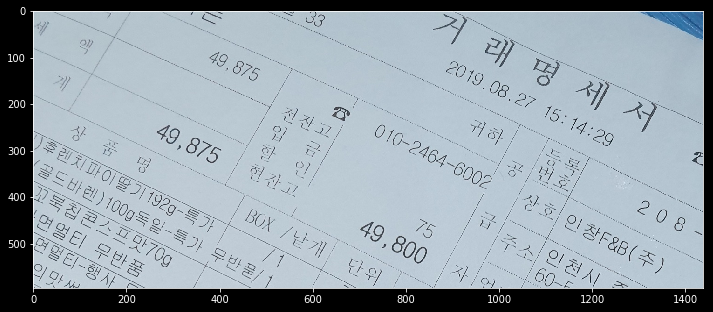

In [167]:
### import cv2  # 이미지 작업   -> opencv python 설치
import cv2
import numpy as np # 행렬 계산
import matplotlib.pyplot as plt    # 결과물 시각화
import pytesseract   # 이미지에서 글씨를 읽어내기 위해 사용
from PIL import Image
plt.style.use('dark_background')

#1. 이미지 불러오기
img_car = cv2.imread("C:/programming/myPyCode/BigData/Final_Prjoect/image/hanwha5.jpg")

#2. 높이, 너비, 채널 크기 조절
height, width, channel = img_car.shape  # 너비, 높이, 채널 저장.

#3. 이미지 확인해보기
plt.figure(figsize=(12,10))
plt.imshow(img_car, cmap='gray')
plt.show()

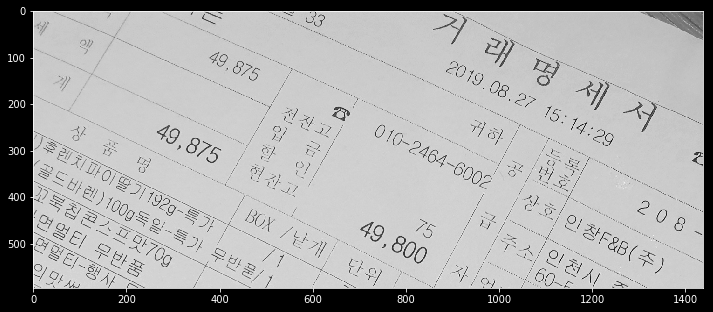

In [168]:
#4. 이미지를 GrayScale로 전환
gray = cv2.cvtColor(img_car, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(gray, cmap = 'gray')
plt.show()

In [169]:
#  5. Adaptive Thresholding 진행.
# 사용 기법 - GaussianBlur / AdaptiveThreshold
# GaussianBlur 사용 이유 - Noise를 줄이기 위함.
# AdaptiveThreshold 사용 이유 - 노트 참고.
#Threshold란? - '문턱'이라는 뜻.
#이 값을 기준으로 상황이 급격하게 변한다는 뜻. 
#ex)문턱값이 0.5일 때, 0.5를 기준으로 작으면 0, 보다 크면 1로 설정.(이진화와 비슷)

In [170]:
#  5.1과 5.2는 가우시안 blur를 사용하고 안하고를 비교하기 위함.
# 5.1. Threshold only만 진행. 가우시안 blur X
img_thresh = cv2.adaptiveThreshold(
    gray,
    maxValue = 255.0,
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType = cv2.THRESH_BINARY_INV,
    blockSize =19,
    C=9
)

In [171]:
img_thresh # only Threshold

array([[  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0]], dtype=uint8)

In [172]:
# 5.2 가우시안 blur + Threshold 진행.
img_blurred = cv2.GaussianBlur(gray, ksize = (5,5), sigmaX = 0)

In [173]:
img_blurred 

array([[192, 192, 192, ..., 102, 100, 100],
       [192, 192, 192, ..., 103, 101, 101],
       [192, 192, 192, ..., 105, 103, 102],
       ...,
       [208, 204, 194, ..., 200, 200, 200],
       [206, 196, 174, ..., 200, 200, 200],
       [204, 191, 163, ..., 200, 200, 200]], dtype=uint8)

In [174]:
img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue = 255.0,
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType = cv2.THRESH_BINARY_INV,
    blockSize = 19,
    C = 9
)

In [175]:
img_blur_thresh # GaussianBlur + Threshold

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0]], dtype=uint8)

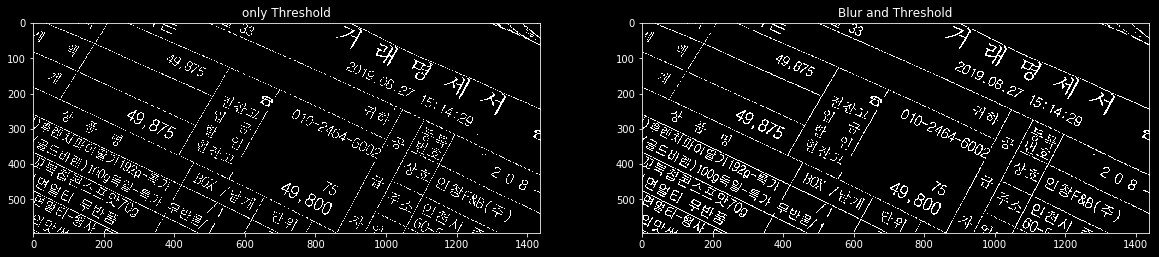

In [176]:
# 5.3. only Threshold vs GaussianBlur + Threshold 비교
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("only Threshold")
plt.imshow(img_thresh, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Blur and Threshold")
plt.imshow(img_blur_thresh, cmap='gray')
plt.show()

## 해석 
## -> Blur를 진행했을 때 Noise가 더 없어지는 것을 볼 수 있음.
## -> AdaptiveThreshold를 통해, 검은색과 흰색으로 나눌 수 있음.
##  이렇게 진행함으로써, 컴퓨터가 번호를 좀 더 찾기 쉽게 하기 위함.

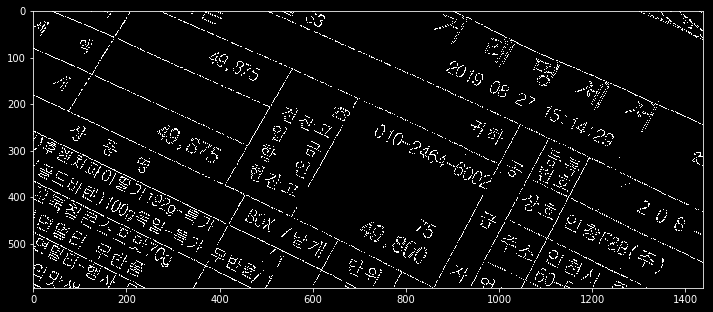

In [177]:
# 6. Contours 찾기.
# Contours는 윤곽선을 의미.
#★★★★★윤곽선을 통해 번호판의 위치를 찾아낼 것임.★★★★★

# 참고 사이트
#https://datascienceschool.net/view-notebook/f9f8983941254a34bf0fee42c66c5539/
#  컨투어란? 
# 동일한 색 또는 동일한 픽셀값(강도, intensity)을 가지고 있는 영역의 경계선을 
#연결한 선. 윤곽선, 외형을 파악하는 데 사용. 결과물의 정확성을 위하여 임계처리
#등을 통해 이미지를 이진화 하여 사용.


#6.1. only Threshold
contours1, _= cv2.findContours(  
    img_thresh,
    mode = cv2.RETR_LIST, # 모든 컨투어 라인을 찾지만, 상하구조 관계를 구성하지않음.
    method = cv2.CHAIN_APPROX_SIMPLE # 컨투어인을 그릴 수 있는 포인트만 반환
)

temp_result1= np.zeros((height, width, channel), dtype = np.uint8) # height, width, channel 크기에 맞게, 0으로 초기화

cv2.drawContours(temp_result1, contours = contours1, contourIdx = -1, color = (255,255,255))  
## findContours에서 있던 것을 drawContours를 통해 그림을 그릴 수 있음.
## temp_result에 컨투어를 그림.
## contourIdx = -1 은 전체를 그리기 위함.
## color에서 윤곽선은 흰색으로.

plt.figure(figsize=(12,10))
plt.imshow(temp_result1)   # temp_result를 보여준다.
plt.show()

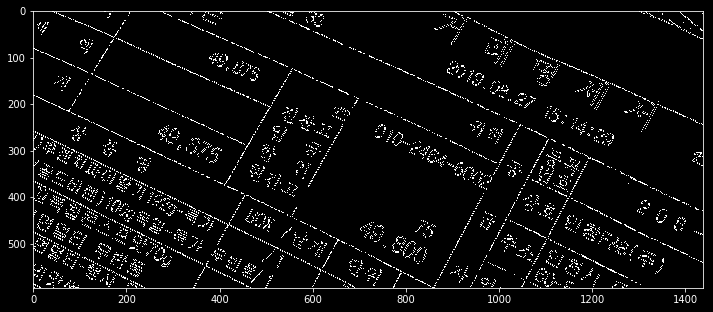

In [178]:
#6.2. 가우시안 blur + Threshold 진행. -> 6.1보다 노이즈가 적음.
contours2, _ = cv2.findContours(  
    img_blur_thresh,
    mode = cv2.RETR_LIST, # 모든 컨투어 라인을 찾지만, 상하구조 관계를 구성하지않음.
    method = cv2.CHAIN_APPROX_SIMPLE # 컨투어인을 그릴 수 있는 포인트만 반환
)

temp_result2= np.zeros((height, width, channel), dtype = np.uint8) # height, width, channel 크기에 맞게, 0으로 초기화

cv2.drawContours(temp_result2, contours = contours2, contourIdx = -1, color = (255,255,255))
## findContours에서 있던 것을 drawContours를 통해 그림을 그릴 수 있음.

plt.figure(figsize=(12,10))
plt.imshow(temp_result2)
plt.show()

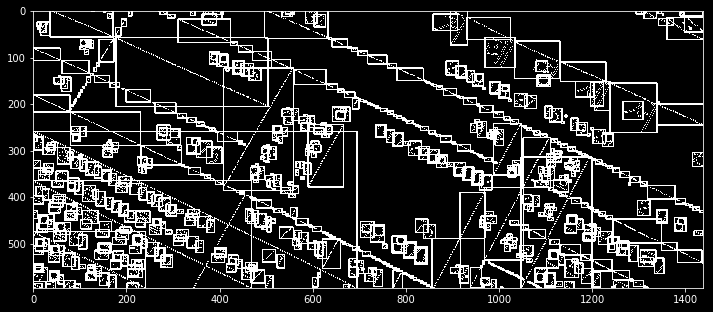

In [179]:
###### 앞으로 윤곽선이 noise가 없는 데이터를 이용할 것임(blur + Threshold) ###########
# 7. 윤곽선을 직사각형으로 만들기.
contours_dict = []
for contour in contours2:
    x, y, w, h = cv2.boundingRect(contour)  # cv2.boundingRect() 윤곽선을 감싸는 사각형을 구한다. => 사각형 범위 찾기
    cv2.rectangle(temp_result2, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness = 2)  # 이미지에 사각형을 그린다.
    
    # dict에 데이터 삽입
    contours_dict.append({  # boundingRect에 해당하는 값들을 저장.
        'contour' : contour,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'cx' : x + (w/2),  # (cx,cy)는 중심 좌표.
        'cy' : y + (h/2)
        
    })
    
# boundingRect에서 만든 그림 확인. => contour를 감싸는 사각형의 모습들을 볼 수 있을 것임.
plt.figure(figsize=(12,10))
plt.imshow(temp_result2, cmap='gray')
plt.show()

In [180]:
# 8. 위에서 네모를 다음 구간으로 추릴 것임.
MIN_AREA = 80 # boundingRect의 최소 넓이는 80
MIN_WIDTH, MIN_HEIGHT = 2, 8 # boundingRect의 최소 너비와 높이는 2, 8로 지정.
MIN_RATIO, MAX_RATIO = 0.25, 1.0 # boundingRect의 가로, 세로 비율의 최소와 최대

possible_contours = [] # 가능한 boundingRect를 다 저장할 것임.

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']  # 넓이 = 가로 * 세로
    ratio = d['w'] / d['h']  # 비율 = 가로 / 세로
    
    # 위 조건들을 확인하며, 번호판 확률이 높은 친구들을 possible_contours에 저장하자.
    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt   
        cnt += 1
        ## 각 윤곽선의 idx 값을 매겨 놓고, 나중에 조건에 맞는 윤곽선들의 idx만 따로 빼내기 위해 idx 값 지정.
        possible_contours.append(d)

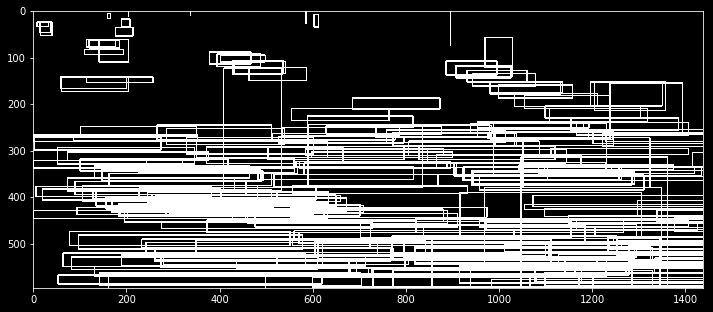

In [181]:
# 9. 조건에 맞는 boundingRect를 추려보기
temp_result2 = np.zeros((height, width, channel), dtype=np.uint8)  # 값을 초기화 시키기.

for d in possible_contours:
    cv2.rectangle(temp_result2, pt1=(d['x'], d['y']), pt2 = (d['x'] + d['y'], d['y']+d['h']), color= (255,255,255), thickness = 2)
    

plt.figure(figsize=(12,10))
plt.imshow(temp_result2, cmap='gray')
plt.show()
## 어려웠던 점 -> 아우디 차량은 마크가 000 이다 보니, boundingRect를 진행했을 때 번호판과 헷갈릴 수도 있음.

In [182]:
# .1과 .2를 나눌 것임 
#'아우디 마크를 제거하지 않았을 때' vs '아우디 마크를 제거했을 때'

#10.1. 진짜 번호판일 것 같은 boundingRect를 추려내기. -> 순차적으로 정리 되어 있는 것들을 확인한다.
# 규칙 정하기 - 노트 참고1
MAX_DIAG_MULTIPLYER = 5  # diag의 중심점끼리의 거리가 diag length의 __ 배 안쪽으로 있어야 함.
MAX_ANGLE_DIFF = 12.0  # contour와 contour와의 각도 최댓값
MAX_AREA_DIFF = 0.5  # contour와 contour 면적 차이가 ___이하(비율로 계산할 것임)
MAX_WIDTH_DIFF = 0.8  # contour와 contour의 너비 차이가 ____ 이하(비율로 계산할 것임)
MAX_HEIGHT_DIFF = 0.2  # contour와 contour의 높이 차이가 ____ 이하(비율로 계산할 것임)
MIN_N_MATCHED = 5  # 위 다섯 개의 변수를 만족하는 네모가 적어도 7개 이상이어야 함. 


#####################
##### 함수 코드 #####
#####################
# 재귀적 방식으로 번호판 후보군을 찾을 것임.
def find_chars(contour_list):
    matched_result_idx = [] # 최종적을 남는 index 값들을 저장.
    
    
    #  이중 for문을 돎으로써, contour간에 계산 비교하기 - 노트 참고
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:  # contour가 같으면 넘어감.
                continue
            
            #노트참고2 - 위 변수 중 MAX_DIAG_MULTIPLYER와 값을 비교하기 위함.
            dx = abs(d1['cx'] - d2['cx'])  #대각선 길이 구하기 위한 dx
            dy = abs(d1['cy'] - d2['cy'])  #대각선 길이 구하기 위한 dy
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # contour1의 대각선 길이 
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            ## np.linalg.norm(a-b)  => 벡터 a와 벡터 b 사이의 거리를 구한다.
            
            
            #노트참고3 - 위 변수 중 MAX_ANGLE_DIFF와 값을 비교하기 위함.=> dx, dy 계산이 있어야함.
            if dx == 0:  # dx = 0이면 contour1과 contour2간의 관계가 각도가 90도로 이루어짐.
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))  # arctan을 통해 각도를 계산한다.
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])  # 면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w']   # 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h']  # 높이의 비율
            
            # 위 파라미터 기준에 맞는 친구들만 matched_contours_idx에 집어넣는다.
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])  # 노트참고4 - d1과 함께하는 d2들 중 조건에 만족하면 모두 추가하기.
                 
        matched_contours_idx.append(d1['idx']) # d2와 비교했던 d1추가.
        
        # 번호판 갯수 확인 -> 윤곽선 갯수가 3보다 작으면 번호판일 확률이 낮다. 왜냐하면 한국 번호판은 총 7자리이기 때문.
        if len(matched_contours_idx) < MIN_N_MATCHED: # if 조건을 만족하면 번호판이 아님. 따라서 continue 진행.
            continue
        
        matched_result_idx.append(matched_contours_idx)  # 통과했으면 최종 후보군에 넣을 것임.
        
        # 최종 후보군이 아닌 애들을 한 번 더 비교해볼 것임.
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:  # mathced_contours_idx에 값이 없으면,
                unmatched_contour_idx.append(d4['idx']) #unmatched_contour_idx에 값을 대입하자.
                
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx) # 전체 contour와 unmatched contour의 교집합을 찾자!!!
        ## np.take(a, idx) => a에서 idx와 같은 인덱스의 값만 추출.
        
        # ★★★재귀 진행★★★ -> 후보군인 것들을 제거하면서 후보군이 아닌 값들 중 후보일 것으로 예상 되는 값을 찾기 위함.
        recursive_contour_list = find_chars(unmatched_contour)
        
        # 살아남은 것을 matched_result_idx에 저장.
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        
        break
        
    return matched_result_idx

#####################
##### 메인 코드 #####
#####################
result_idx = find_chars(possible_contours) 

matched_result = [] 
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list)) # 전체와 부분을 비교해본다.

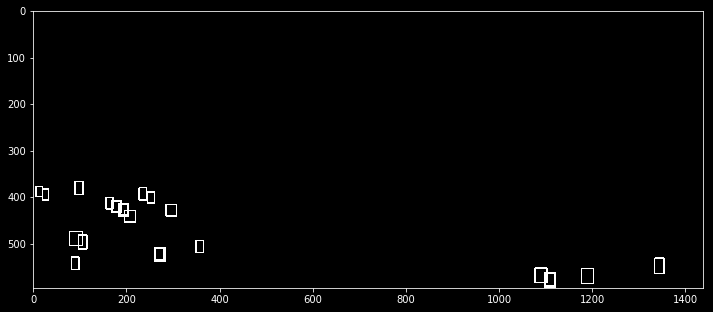

In [183]:
# 11.1. matched_result 시각화 진행 => 최종적으로 번호판 위치를 확인하기 위함.
temp_result2 = np.zeros((height, width, channel), dtype = np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result2, pt1=(d['x'], d['y']), pt2 = (d['x'] + d['w'], d['y'] + d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12,10))
plt.imshow(temp_result2, cmap='gray')
plt.show()

## 아우디 마크 때문일 것으로 추정. => 아우디 차량은 번호판 인식이 좀 힘들다는 것을 알 수 있음.

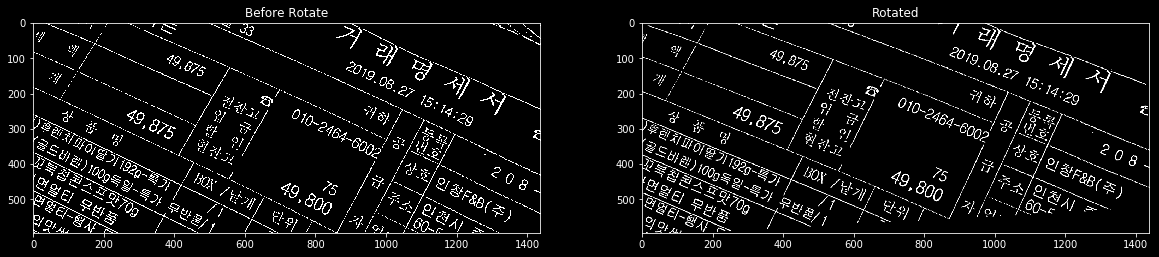

In [184]:
# 12.1. 비틀어진 이미지 바로 만들기. 
# Affine Transform 활용 -> 비틀어진 이미지를 바로 만들기.
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10


for i, matched_chars in enumerate(matched_result): # enumerate => (인덱스, 컬렉션의 원소) 형태로 추출 -> 참고 사이트 : https://wikidocs.net/16045
    sorted_chars = sorted(matched_chars, key = lambda x : x['cx'])  # x 방향으로 순차적으로 정렬 해주기.
    
    
    
    #  노트참고5
    # plate의 cx, cy, width, height를 계산함. => plate_x, plate_y, plate_width, plate_height가 변수임.
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2 # center x => (처음 + 마지막) / 2 => central x
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2 # center y => (처음 + 마지막) / 2 => central y
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
    
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    # 수평선을 기준으로 비틀어진 각도를 바로 잡기 위함.
    #각도를 계산하기 위해 arcsin 사용.
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy'] # 컨투어끼리에서 높이 계산
    triangle_hypotenus = np.linalg.norm(   # contour간의 대각선 길이 계산
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
# '라디안' -> '도'로 전환
angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus)) 
    
# RotationMatrix를 구하기.
rotation_matrix = cv2.getRotationMatrix2D(center = (plate_cx, plate_cy), angle = angle, scale = 1.0)
    
# 비틀어진 이미지를 바로 잡기. => warpAffine() 활용. ---> getRotationMatrix2D가 전제.
img_rotated = cv2.warpAffine(img_blur_thresh, M = rotation_matrix, dsize = (width, height))

# '각도 바로잡기 전' vs '각도 바로잡은 후' 사진 비교
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Before Rotate')
plt.imshow(img_blur_thresh, cmap='gray')
plt.subplot(1,2,2)
plt.title('Rotated')
plt.imshow(img_rotated, cmap='gray')
plt.show()
## 설명 - 보면, 아우디 마크를 기준으로 사진이 올바르게 이루어짐을 확인할 수 있다. '아우디 마크', '번호판' 중 위의 것을 먼저 인식.

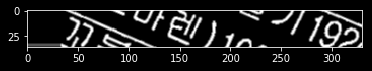

In [185]:
# 13.1. 바로잡은 사진에서 원하는 부분만 사진으로 추출.
img_cropped = cv2.getRectSubPix(
    img_rotated,
    patchSize = (int(plate_width), int(plate_height)),
    center = (int(plate_cx), int(plate_cy))
)

plt.imshow(img_cropped, cmap='gray')
plt.show()

## 아우디 마크가 아름답게 나왔다. => 그러나 내가 원하는 번호판 추출이 불가함. 따라서 전처리 과정에 대해 고민해봄.

In [186]:
# 따라서 한국 번호판은 7자리 이상임을 확인할 수 있기 때문에 MIN_N_MATCHED = 3 -> MIN_N_MATCHED = 7 로 바꾼다.
#(MIN_N_MATCHED 변수 값 변경 외에는 모두 값이 같음.)

In [187]:
#10.2. 진짜 번호판일 것 같은 boundingRect를 추려내기. -> 순차적으로 정리 되어 있는 것들을 확인한다.
# 규칙 정하기 - 노트 참고1
MAX_DIAG_MULTIPLYER = 5  # diag의 중심점끼리의 거리가 diag length의 __ 배 안쪽으로 있어야 함.
MAX_ANGLE_DIFF = 12.0  # contour와 contour와의 각도 최댓값
MAX_AREA_DIFF = 0.5  # contour와 contour 면적 차이가 ___이하(비율로 계산할 것임)
MAX_WIDTH_DIFF = 0.8  # contour와 contour의 너비 차이가 ____ 이하(비율로 계산할 것임)
MAX_HEIGHT_DIFF = 0.2  # contour와 contour의 높이 차이가 ____ 이하(비율로 계산할 것임)
MIN_N_MATCHED = 7  # 위 다섯 개의 변수를 만족하는 네모가 적어도 3개 이상이어야 함.


#####################
##### 함수 코드 #####
#####################
# 재귀적 방식으로 번호판 후보군을 찾을 것임.
def find_chars(contour_list):
    matched_result_idx = [] # 최종적을 남는 index 값들을 저장.
    
    
    #  이중 for문을 돎으로써, contour간에 계산 비교하기 - 노트 참고
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:  # contour가 같으면 넘어감.
                continue
            
            #노트참고2 - 위 변수 중 MAX_DIAG_MULTIPLYER와 값을 비교하기 위함.
            dx = abs(d1['cx'] - d2['cx'])  #대각선 길이 구하기 위한 dx
            dy = abs(d1['cy'] - d2['cy'])  #대각선 길이 구하기 위한 dy
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # contour1의 대각선 길이 
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            ## np.linalg.norm(a-b)  => 벡터 a와 벡터 b 사이의 거리를 구한다.
            
            
            #노트참고3 - 위 변수 중 MAX_ANGLE_DIFF와 값을 비교하기 위함.=> dx, dy 계산이 있어야함.
            if dx == 0:  # dx = 0이면 contour1과 contour2간의 관계가 각도가 90도로 이루어짐.
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))  # arctan을 통해 각도를 계산한다.
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])  # 면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w']   # 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h']  # 높이의 비율
            
            # 위 파라미터 기준에 맞는 친구들만 matched_contours_idx에 집어넣는다.
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])  # 노트참고4 - d1과 함께하는 d2들 중 조건에 만족하면 모두 추가하기.
                 
        matched_contours_idx.append(d1['idx']) # d2와 비교했던 d1추가.
        
        # 번호판 갯수 확인 -> 윤곽선 갯수가 3보다 작으면 번호판일 확률이 낮다. 왜냐하면 한국 번호판은 총 7자리이기 때문.
        if len(matched_contours_idx) < MIN_N_MATCHED: # if 조건을 만족하면 번호판이 아님. 따라서 continue 진행.
            continue
        
        matched_result_idx.append(matched_contours_idx)  # 통과했으면 최종 후보군에 넣을 것임.
        
        # 최종 후보군이 아닌 애들을 한 번 더 비교해볼 것임.
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:  # mathced_contours_idx에 값이 없으면,
                unmatched_contour_idx.append(d4['idx']) #unmatched_contour_idx에 값을 대입하자.
                
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx) # 전체 contour와 unmatched contour의 교집합을 찾자!!!
        ## np.take(a, idx) => a에서 idx와 같은 인덱스의 값만 추출.
        
        # ★★★재귀 진행★★★ -> 후보군인 것들을 제거하면서 후보군이 아닌 값들 중 후보일 것으로 예상 되는 값을 찾기 위함.
        recursive_contour_list = find_chars(unmatched_contour)
        
        # 살아남은 것을 matched_result_idx에 저장.
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        
        break
        
    return matched_result_idx

#####################
##### 메인 코드 #####
#####################
result_idx = find_chars(possible_contours) 

matched_result = [] 
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list)) # 전체와 부분을 비교해본다.

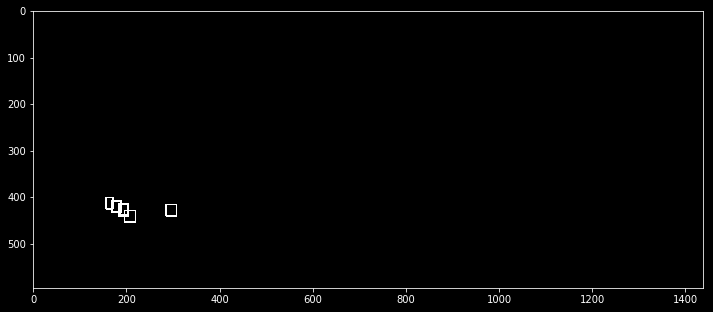

In [188]:
# 11.2 matched_result 시각화 진행 => 최종적으로 번호판 위치를 확인하기 위함.
temp_result2 = np.zeros((height, width, channel), dtype = np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result2, pt1=(d['x'], d['y']), pt2 = (d['x'] + d['w'], d['y'] + d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12,10))
plt.imshow(temp_result2, cmap='gray')
plt.show()

## 설명 - 번호판만 추출했음.

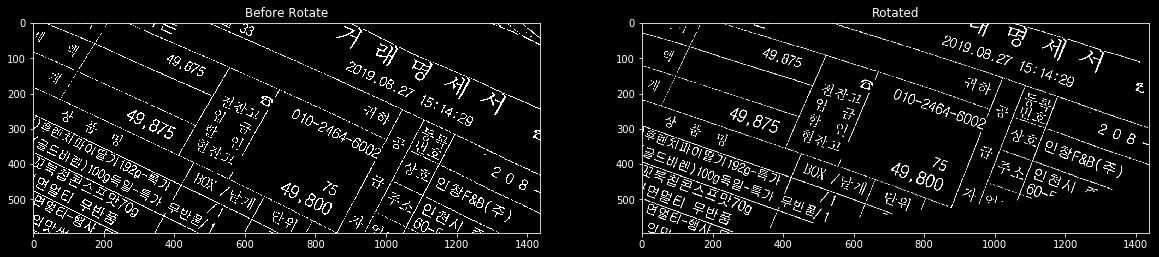

In [189]:
# 12.2 비틀어진 이미지 바로 만들기. 
# Affine Transform 활용 -> 비틀어진 이미지를 바로 만들기.
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10


for i, matched_chars in enumerate(matched_result): # enumerate => (인덱스, 컬렉션의 원소) 형태로 추출 -> 참고 사이트 : https://wikidocs.net/16045
    sorted_chars = sorted(matched_chars, key = lambda x : x['cx'])  # x 방향으로 순차적으로 정렬 해주기.
    
    
    
    #  노트참고5
    # plate의 cx, cy, width, height를 계산함. => plate_x, plate_y, plate_width, plate_height가 변수임.
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2 # center x => (처음 + 마지막) / 2 => central x
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2 # center y => (처음 + 마지막) / 2 => central y
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
    
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    # 수평선을 기준으로 비틀어진 각도를 바로 잡기 위함.
    #각도를 계산하기 위해 arcsin 사용.
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy'] # 컨투어끼리에서 높이 계산
    triangle_hypotenus = np.linalg.norm(   # contour간의 대각선 길이 계산
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
# '라디안' -> '도'로 전환
angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus)) 
    
# RotationMatrix를 구하기.
rotation_matrix = cv2.getRotationMatrix2D(center = (plate_cx, plate_cy), angle = angle, scale = 1.0)
    
# 비틀어진 이미지를 바로 잡기. => warpAffine() 활용. ---> getRotationMatrix2D가 전제.
img_rotated = cv2.warpAffine(img_blur_thresh, M = rotation_matrix, dsize = (width, height))

# '각도 바로잡기 전' vs '각도 바로잡은 후' 사진 비교
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Before Rotate')
plt.imshow(img_blur_thresh, cmap='gray')
plt.subplot(1,2,2)
plt.title('Rotated')
plt.imshow(img_rotated, cmap='gray')
plt.show()
## 설명 - 보면, 번호판을 기준으로 사진이 올바르게 이루어짐을 확인할 수 있다.

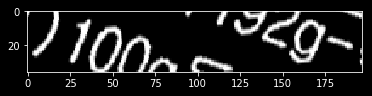

In [190]:
# 목표1. 번호판 위치 찾기 완료.
# 13.2 바로잡은 사진에서 원하는 부분만 사진으로 추출. => getRectSubPix() 함수 사용.
img_cropped = cv2.getRectSubPix(
    img_rotated,
    patchSize = (int(plate_width), int(plate_height)),
    center = (int(plate_cx), int(plate_cy))
)

plt.imshow(img_cropped, cmap='gray')
plt.show()

## 번호판을 올바르게 추출했다.

In [191]:
# 파일 저장. => 파일 저장시, threshold를 한 번 더 사용하기.(화질이 더 좋아지는 것을 확인할 수 있음.)
from PIL import Image
resize_plate = cv2.resize(img_cropped, None, fx = 1.8, fy=1.8,
                         interpolation=cv2.INTER_CUBIC+cv2.INTER_LINEAR)
_, th_plate = cv2.threshold(resize_plate, 150,255, cv2.THRESH_BINARY)
cv2.imwrite('C:/programming/myPyCode/BigData/Final_Prjoect/image/temp.jpg', th_plate)

True

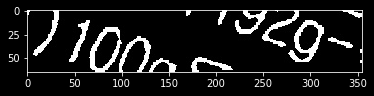

In [192]:
# 파일 읽기
import pytesseract
from PIL import Image

Image = Image.open('C:/programming/myPyCode/BigData/Final_Prjoect/image/temp.jpg')
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract"

chars = pytesseract.image_to_string(Image, lang = 'eng') # 이미지에서 string을 뽑아내라.

print(chars)
plt.imshow(Image, cmap='gray')
plt.show()